In [1]:
import argparse
import logging
import math
import os
import random
import shutil
import yaml
import shutil
import json
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed


/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/oa_venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/workspace/oa_venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig
import wandb

In [3]:
import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DDIMScheduler
from unet_2d_condition import UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

/workspace/oa_venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/workspace/oa_venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
import pickle
from datetime import datetime
from projector import Projector
import numpy as np

In [5]:
torch.autograd.set_detect_anomaly(True)

PIL_INTERPOLATION = {
        "linear": PIL.Image.Resampling.BILINEAR,
        "bilinear": PIL.Image.Resampling.BILINEAR,
        "bicubic": PIL.Image.Resampling.BICUBIC,
        "lanczos": PIL.Image.Resampling.LANCZOS,
        "nearest": PIL.Image.Resampling.NEAREST,
}



In [6]:
logger = get_logger(__name__)


def init_wanddb(config=None):
    wandb.init(project="OneActor", entity="eadishcheva")
    run = wandb.init(
        # Set the wandb entity where your project will be logged (generally your team name).
        entity="eadishcheva",
        # Set the wandb project where this run will be logged.
        project="OneActor",
        # Track hyperparameters and run metadata.
        config=config,
    )
    return run


In [7]:
import torch.nn.functional as F

In [8]:
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str = None, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")
    
def save_progress(projector, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_projector = (
        accelerator.unwrap_model(projector)
    )

    torch.save(learned_projector, save_path)


human_templates = [
    "a photo of a {}",
    "a portrait of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a beautiful {}",
    "a realistic photo of a {}",
    "a dark photo of the {}",
    "a character photo of a {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a face photo of the {}",
    "a cropped face of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a high-quality photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "an image of a {}",
    "a snapshot of a {}",
    "a person's photo of a {}",
    "an individual's photo of a {}",
]

In [9]:
    
# input: latent_sequence(con&uncon), prompt_embed, prompt, base_prompt
# input: latent_sequence(con&uncon), prompt_embed, prompt, base_prompt
class OneActorDataset(Dataset):
    def __init__(
        self,
        target_dir,
        use_mask=False,
        repeats=200,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        config=None,
    ):
        self.target_root = target_dir
        self.size = 1024
        self.latent_size = 128

        self.base_condition = config['base']
        self.flip_p = flip_p
        self.neg_num = 5

        self.use_mask = use_mask
        
        self._length = repeats
        
        self.target_image_paths = self.target_root + "/target.jpg"
        self.base_image_paths = [
            os.path.join(f"{self.target_root}/base", file_path) for file_path in os.listdir(f"{self.target_root}/base") \
                if os.path.splitext(file_path)[1] == '.jpg']

        self.num_base = len(self.base_image_paths)

        self._length = 200
        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]
        
        self.templates = human_templates

        with open(self.target_root+f'/target_data.pkl', 'rb') as f:
            target_data = pickle.load(f)

        with open(self.target_root+f'/base/base_data_list.pkl', 'rb') as f:
            base_data = pickle.load(f)

        self.target_data = target_data
        self.base_data = base_data
        
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)    # randomly flip images

        self.h_mid = self.target_data['h_mid']
        self.prompt_embed = self.target_data['prompt_embed']
        self.base_mid = [h['h_mid'][-1] for h in self.base_data]

        if self.use_mask:
            self.target_mask = self.target_data['mask_64']
            self.target_mask = self.target_mask.unsqueeze(0).unsqueeze(0)  # => (1, 1, H, W)
            self.target_mask = F.interpolate(self.target_mask, (self.latent_size, self.latent_size), mode='bilinear', align_corners=True)
            self.target_mask = self.target_mask.squeeze(0)
            self.base_masks = [torch.ones(size=(1, self.latent_size, self.latent_size))] * self.num_base
            
    def __len__(self):
        return self._length

    
    def __getitem__(self, i):
        example = {}

        imgs = []
        h_mid_list = []
        
        if self.use_mask:
            mask_tensors = []
        # target samples

        imgs.append(self.target_image_paths)
        h_mid_list.append(self.h_mid[-1])
        if self.use_mask:
            mask_tensors.append(self.target_mask)
        
        # base samples
        for i in range(self.neg_num):
            ind = random.randint(0, len(self.base_image_paths)-1)
            imgs.append(self.base_image_paths[ind])
            h_mid_list.append(self.base_mid[ind])
            if self.use_mask:
                mask_tensors.append(self.base_masks[ind])
        
        img_tensors = []
        text_list = []
            
        for n, img_path in enumerate(imgs):
            image = Image.open(img_path)
            if not image.mode == "RGB":
                image = image.convert("RGB")
            # default to score-sde preprocessing
            image = np.array(image).astype(np.uint8)
            image = Image.fromarray(image)
            image = image.resize((self.size, self.size), resample=self.interpolation)
            image_f = self.flip_transform(image)
            flip_ind = image_f != image
            image = image_f
            
            image = np.array(image).astype(np.uint8)
            image = (image / 127.5 - 1.0).astype(np.float32)

            img_tensors.append(torch.from_numpy(image).permute(2, 0, 1))

            text = random.choice(self.templates).format(self.base_condition)
            text_list.append(text)

            if self.use_mask:
                if flip_ind:
                    mask_tensors[n] = torch.flip(mask_tensors[n], [2])
                mask_tensors[n] =  mask_tensors[n].repeat(4, 1, 1)
        if self.use_mask:
            mask_tensors.append(mask_tensors[0])

        img_tensors.append(img_tensors[0])
        text_list.append(text_list[0])
        h_mid_list.append(random.choice(h_mid_list))

        example["pixel_values"] = torch.stack(img_tensors)
        if self.use_mask:
            example["mask_pixel_values"] = torch.stack(mask_tensors)
        example['text'] = text_list
        example['base'] = self.base_condition
        example['h_mid'] = torch.stack(h_mid_list)
    
        return example    

In [10]:
    # get environment configs
    with open("PATH.json","r") as f:
        ENV_CONFIGS = json.load(f)
    # get user configs

In [11]:
    with open("./config/gen_cs_adventure.yaml", "r") as f:
        config = yaml.safe_load(f)
    device = config['device']

In [12]:
    target_dir = './experiments/consistory_adventurer'
    for _, tgt_dirs, _ in os.walk(target_dir):
        break
    
    exp_id = 'exp_2504251627'

    print(f"exp_id = {exp_id}")


    if exp_id not in tgt_dirs:
        print("Base image is not generated")

    target_dir += f"/{exp_id}"


exp_id = exp_2504251627


In [13]:
    
    accelerator_project_config = ProjectConfiguration(project_dir=target_dir, logging_dir='logs')
    accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="fp16",
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()


/workspace/oa_venv/lib/python3.10/site-packages/accelerate/accelerator.py:401: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/29/2025 19:30:27 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



In [14]:
set_seed(1000)

In [15]:
use_mask = True

In [16]:
    now = datetime.now()

    train_id = now.strftime("%y%m%d%H%M") # uuid.uuid4()
    train_id = str(train_id)
    output_dir = f"{target_dir}/output_{train_id}"
    if accelerator.is_main_process:
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(f"{output_dir}/ckpt", exist_ok=True)
        os.makedirs(f"{output_dir}/weight", exist_ok=True)


In [17]:
    pretrained_model_name_or_path = ENV_CONFIGS['paths']['sdxl_path']
    # Load the tokenizers
    tokenizer_one = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=None,
        use_fast=False,
    )
    tokenizer_two = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer_2",
        revision=None,
        use_fast=False,
    )

    # import correct text encoder classes
    text_encoder_cls_one = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path, None
    )
    text_encoder_cls_two = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path, None, subfolder="text_encoder_2"
    )

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
    # Check for terminal SNR in combination with SNR Gamma
    text_encoder_one = text_encoder_cls_one.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder",
    )
    text_encoder_two = text_encoder_cls_two.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder_2",
    )

    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path, subfolder="unet",
    )


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/workspace/oa_venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
{'dynamic_thresholding_ratio', 'variance_type', 'clip_sample_range', 'thresholding'} was not found in config. Values will be initialized to default values.
{'attention_type', 'reverse_transformer_layers_per_block', 'dropout'} was not found in config. Values will be initialized to default values.


In [18]:
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)
    unet.requires_grad_(False)

    # Build projector
    projector = Projector(1280, 2048)
    # Fire projector
    projector.requires_grad_(True)



Projector(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1280, 640, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): Ba

In [19]:
unet.enable_xformers_memory_efficient_attention()

In [20]:
torch.backends.cuda.matmul.allow_tf32 = True

In [21]:
optimizer = torch.optim.AdamW(
        projector.parameters(),  # only optimize the embeddings
        lr=config['lr'],
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-8,
    )

In [22]:
train_dataset = OneActorDataset(
        target_dir=target_dir,
        use_mask=use_mask,
        config=config,
        set='train',
    )

In [23]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0
    )

In [24]:
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader))

max_train_steps = config['epochs'] * num_update_steps_per_epoch
overrode_max_train_steps = True

In [25]:
    lr_scheduler = get_scheduler(
        "constant",
        optimizer=optimizer,
        num_warmup_steps=500 * accelerator.num_processes,
        num_training_steps=max_train_steps * accelerator.num_processes,
        num_cycles=1,
    )

    projector.train()
    # Prepare everything with our `accelerator`.
    projector, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        projector, optimizer, train_dataloader, lr_scheduler
    )

    # For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    # Move vae and unet to device and cast to weight_dtype

    with torch.cuda.amp.autocast(dtype=weight_dtype):
        unet.to(accelerator.device, dtype=weight_dtype)
        text_encoder_one.to(accelerator.device, dtype=weight_dtype)
        text_encoder_two.to(accelerator.device, dtype=weight_dtype)
        vae.to(accelerator.device, dtype=weight_dtype)
    # with torch.cuda.amp.autocast(dtype=torch.float32):
    #     vae.to(accelerator.device)


In [26]:
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader))
    if overrode_max_train_steps:
        max_train_steps = config['epochs'] * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    config['epochs'] = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("OneActor", config=config)

    # Train!
    total_batch_size = config['batch_size'] * accelerator.num_processes


In [27]:
    with open(f"{output_dir}/log_train.log", 'w') as log_file:
        print(f"num_examples: {len(train_dataset)}", file=log_file)
        print(f"num_epochs: {config['epochs']}", file=log_file)
        print(f"batch_size: {config['batch_size']}", file=log_file)
        print(f"total_batch_size: {total_batch_size}", file=log_file)
        print(f"max_train_steps: {max_train_steps}", file=log_file)
        print(f"target_dir: '{target_dir}'", file=log_file)
        print(f"train_id: '{train_id}'", file=log_file)
        print(f"use_mask: '{use_mask}'", file=log_file)
        # print(f"mask_power: '{mask_power}'", file=log_file)
        # print(f"mask_alpha: '{mask_alpha}'", file=log_file)

    run = init_wanddb(config={
        "thema":config['target_dir'],
        "exp_id":exp_id,
        "model_id":train_id,
        "use_mask":use_mask,
        # "mask_power":mask_power,
        # "mask_alpha":mask_alpha,
        "epoch":train_dataset.__len__(),
    })


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eadishcheva to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [28]:
    global_step = 0
    first_epoch = 0
initial_global_step = 0

In [29]:
    progress_bar = tqdm(
        range(0, max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )
    
    best_loss = 1000.0


Steps:   0%|          | 0/200 [00:00<?, ?it/s]

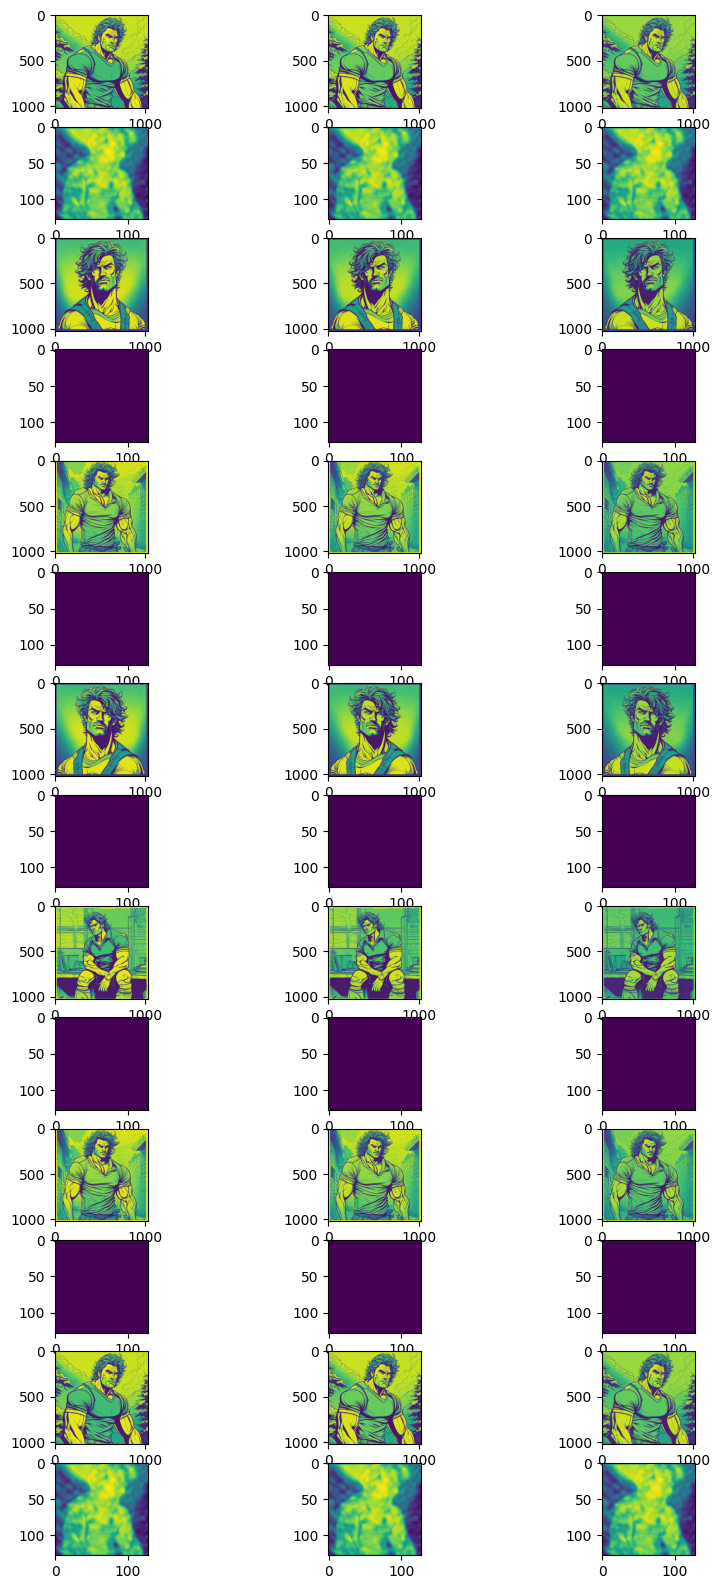

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
import random

ds = train_dataset[random.randint(0, 100)]

f, axarr = plt.subplots(2 * len(ds['pixel_values']), 3, figsize=(10, 20))

for img_num in range(len(ds['pixel_values'])):
    for n in range(3):
        axarr[img_num * 2][n].imshow(ds['pixel_values'][img_num][n])
    for n in range(3):
        axarr[img_num * 2 + 1][n].imshow(ds['mask_pixel_values'][img_num][n])
plt.show()

In [31]:
    mask_power = 0.5
    best_loss = 1000.0
            
    for epoch in range(first_epoch, config['epochs']):
        projector.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(projector):
   
                images = batch["pixel_values"][0].to(dtype=torch.float16)
                latents = vae.encode(images).latent_dist.sample().detach()                    
                latents.to(dtype=weight_dtype)
                latents = latents * vae.config.scaling_factor
                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                noise[-1] = noise[0]    # aver is the same as target
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()
                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                if use_mask:            
                    mask_latents = batch["mask_pixel_values"][0].to(dtype=weight_dtype)

                    noisy_mask_latents = ((1 - noise_scheduler.alphas_cumprod[timesteps.cpu()])**mask_power).view(bsz, 1, 1, 1).to(device)
                    noisy_mask_latents = noisy_mask_latents.to(device)
                    noisy_mask_latents = noisy_mask_latents \
                            + ((noise_scheduler.alphas_cumprod[timesteps.cpu()])**mask_power).view(bsz, 1, 1, 1).to(device) * mask_latents
    
                # time ids
                def compute_time_ids(original_size, crops_coords_top_left):
                    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
                    target_size = (1024, 1024)
                    add_time_ids = list(original_size + crops_coords_top_left + target_size)
                    add_time_ids = torch.tensor([add_time_ids])
                    with torch.cuda.amp.autocast(dtype=weight_dtype):
                        add_time_ids = add_time_ids.to(accelerator.device)
                    return add_time_ids # tensor(1, 6)
                
                original_size = (1024, 1024)
                crops_coords_top_left = (0, 0)
                add_time_ids = compute_time_ids(original_size, crops_coords_top_left).repeat(bsz, 1).to(accelerator.device)
                unet_added_conditions = {"time_ids": add_time_ids}
    
                text_encoders = [text_encoder_one, text_encoder_two]
                tokenizers = [tokenizer_one, tokenizer_two]
                # Get the text embedding for conditioning
                prompt_embeds_batch_list = []
                add_text_embeds_batch_list = []
                delta_emb = projector(batch['h_mid'][0, :, -1].to(device)) # torch.size(bs, 1280, 32, 32) -> torch.size(bs, 2048)
                delta_emb_aver = delta_emb[1:-1].mean(dim=0, keepdim=True)
                for b_s in range(bsz): # 1*target+n*base+1*aver
                    prompt = batch['text'][b_s][0] # str
                    prompt_embeds_list = []
    
                    first = 1
                    for tokenizer, text_encoder in zip(tokenizers, text_encoders):
    
                        text_inputs = tokenizer(
                            prompt,
                            padding="max_length",
                            max_length=tokenizer.model_max_length,
                            truncation=True,
                            return_tensors="pt",
                        )
                        tokens = tokenizer.encode(prompt)
                        
                        if first:
                            for i, token in enumerate(tokens):
                                if tokenizer.decode(token) == batch['base'][0]:
                                    base_token_id = i
                                    first = 0
                                    break
                        text_input_ids = text_inputs.input_ids
                        prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)
                        pooled_prompt_embeds = prompt_embeds[0]
                        prompt_embeds = prompt_embeds.hidden_states[-2]
                        prompt_embeds_list.append(prompt_embeds)
                    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)    # tensor(1, 77, 2048)
    
                    if b_s == bsz-1:
                        delta_emb_ = delta_emb_aver
                    else:
                        delta_emb_ = delta_emb[b_s:b_s+1]
                    prompt_embeds[:, base_token_id, :] = prompt_embeds[:, base_token_id, :] + delta_emb_

                    prompt_embeds_batch_list.append(prompt_embeds)
                    add_text_embeds_batch_list.append(pooled_prompt_embeds)
                
                prompt_embeds = torch.concat(prompt_embeds_batch_list, dim=0)
                add_text_embeds = torch.concat(add_text_embeds_batch_list, dim=0).to(accelerator.device)
    
                unet_added_conditions.update({"text_embeds": add_text_embeds})
                prompt_embeds = prompt_embeds.to(accelerator.device)
    
    
                # Predict the noise residual
                dtype = unet.dtype

                noisy_latents = noisy_latents.to(dtype)
                prompt_embeds = prompt_embeds.to(dtype)
                timesteps = timesteps.to(dtype)
                unet_added_conditions["text_embeds"] = unet_added_conditions["text_embeds"].to(dtype)
                unet_added_conditions["time_ids"] = unet_added_conditions["time_ids"].to(dtype)

                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=prompt_embeds, added_cond_kwargs=unet_added_conditions).sample
    
    
                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if use_mask:
                    loss_target = F.mse_loss(model_pred[:1].float() * noisy_mask_latents[:1].float(),
                                             target[:1].float() * noisy_mask_latents[:1].float(), reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float() * noisy_mask_latents[1:-1].float(),
                                             target[1:-1].float() * noisy_mask_latents[1:-1].float(), reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float() * noisy_mask_latents[-1:].float(),
                                             target[-1:].float() * noisy_mask_latents[-1:].float(), reduction="mean")
                else:
                    loss_target = F.mse_loss(model_pred[:1].float(),
                                             target[:1].float(), reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float(),
                                             target[1:-1].float(), reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float(),
                                             target[-1:].float(), reduction="mean")
                    
                loss = loss_target + config['lambda1'] * loss_base + config['lambda2'] * loss_aver    
                avg_loss = accelerator.gather(loss.repeat(config['batch_size'])).mean()
                train_loss += avg_loss.item()

                run.log({"loss": loss})


                accelerator.backward(loss)
    
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % config['save_steps'] == 0:
                    weight_name = (
                        f"learned-projector-steps-{global_step}.pth"
                    )
                    save_path = os.path.join(output_dir, 'weight', weight_name)

                    save_progress(
                        projector,
                        accelerator,
                        save_path,
                    )
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    best_step = initial_global_step + global_step
                    print(f'Best loss:{best_loss} @@@ Step:{best_step}')
                    weight_name = (
                        f"best-learned-projector.pth"
                    )
                    save_path = os.path.join(output_dir, 'weight', weight_name)

                    save_progress(
                        projector,
                        accelerator,
                        save_path,
                    )

                if accelerator.is_main_process:
                    if global_step % config['checkpointing_steps'] == 0:
                        save_path = os.path.join(output_dir, 'ckpt', f"checkpoint-{initial_global_step + global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"loss": train_loss, "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            train_loss = 0.0

    # Create the pipeline using the trained modules and save it.
    accelerator.wait_for_everyone()
   
    print(f'Best loss:{best_loss} @@@ Step:{best_step}')
    accelerator.end_training()
    # Finish the run and upload any remaining data.
    run.finish()


/workspace/oa_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/workspace/oa_venv/lib/python3.10/site-packages/diffusers/models/lora.py:228: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 